In [1]:
import os
import anndata as an
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from deside.utility import ExpObj, set_fig_style, sorted_cell_types, read_xy, get_corr, calculate_rmse, read_cancer_purity, check_dir
from deside.plot import plot_pca
from deside.utility.read_file import ReadH5AD
from matplotlib_venn import venn2
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-01-09 10:12:05.960946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
result_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/'
dataset_dir = r'../datasets/'
fig_dir = './fig2/'

#### Comparing simulated dataset and TCGA in latent space

In [3]:
dataset_name_mapping = {'Mixed_N100K_random': 'D0', 'Mixed_N100K_segment_filtered': 'D1', 'Mixed_N100K_segment_without_filtering': 'D2'}
# dataset_name_mapping_b = {'Mix_N30K_R': 'Simu. (random)', 'TCGA': 'TCGA', ''}

##### Mixed_N100_random

In [4]:
def read_lower_dim(result_dir, dataset_name, layer_name, dataset_name_mapping, n_cells=5000, low_dim_type='UMAP'):
    file_path = os.path.join(result_dir, f'{dataset_name}/{layer_name}_{low_dim_type.lower()}_lower_dim.csv')
    lower_dim = pd.read_csv(file_path, index_col=0)
    selected_cells = []
    selected_part1 = lower_dim.loc[lower_dim['class'] == 'TCGA', :].sample(n_cells)
    for _ in dataset_name.split('-'):
        selected_part2 = lower_dim.loc[lower_dim['class'] == dataset_name_mapping[_], :].sample(n_cells)
        selected_cells += selected_part2.index.to_list()
    lower_dim_selected = lower_dim.loc[lower_dim.index.isin(selected_part1.index.to_list() + selected_cells), :].copy()
    lower_dim_selected = lower_dim_selected[~lower_dim_selected.index.duplicated()]
    # umap_lower_dim_selected['class'] = umap_lower_dim_selected['class'].map(dataset_name_mapping_b)
    print('part1: ', selected_part1.shape, 'total: ', lower_dim_selected.shape)
    return lower_dim_selected

In [5]:
def plot_jointplot(data, fig_result_path, color, low_dim_type='UMAP'):
    g1 = sns.jointplot(x=f'{low_dim_type}1', y=f'{low_dim_type}2', data=data, kind='scatter', hue='class', s=2, height=1.3, space=0, rasterized=True, palette=color)
    g1_ax = g1.ax_joint
    g1_ax.set_yticks([])
    g1_ax.set_xticks([])
    g1_ax.legend([],[], frameon=False)
    g1legend = g1_ax.legend(loc='upper left', fontsize=6, borderpad=0, handletextpad=0)
    for _ in g1legend.legendHandles:
        _.set_sizes([1])
    # g1legend.borderpad = 100
    # sns.despine(g1_ax)
    g1.ax_marg_x.tick_params(axis='x', which='both', top=False)
    g1.ax_marg_x.grid(False)
    g1.ax_marg_y.tick_params(axis='y', which='both', right=False)
    g1.ax_marg_y.grid(False)
    g1_ax.set_xlabel('')
    g1_ax.set_ylabel('')

    plt.savefig(fig_result_path, dpi=300)

In [6]:
dataset2color = {'TCGA': 'C5', 'D0': 'C0', 'D1': 'C1', 'D2': 'C2'}

--- Mixed_N100K_random, l_first ---
part1:  (5000, 4) total:  (10000, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


--- Mixed_N100K_random, l_last ---
part1:  (5000, 4) total:  (10000, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


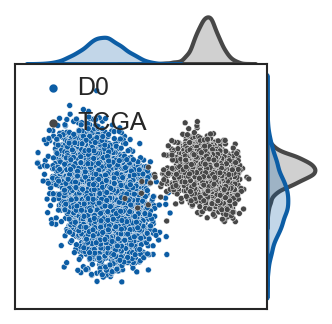

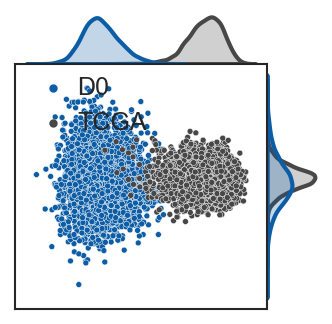

In [7]:
dataset_name = 'Mixed_N100K_random'
for l_name in ['l_first', 'l_last']:
    print(f'--- {dataset_name}, {l_name} ---')
    lower_dim = read_lower_dim(result_dir, dataset_name, layer_name=l_name, dataset_name_mapping=dataset_name_mapping, low_dim_type='PCA')
    plot_jointplot(data=lower_dim, fig_result_path=os.path.join(fig_dir, f'{l_name}_{dataset_name}.svg'), color=dataset2color, low_dim_type='PC')

--- Mixed_N100K_segment_filtered, l_first ---
part1:  (5000, 4) total:  (10000, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


--- Mixed_N100K_segment_filtered, l_last ---
part1:  (5000, 4) total:  (10000, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


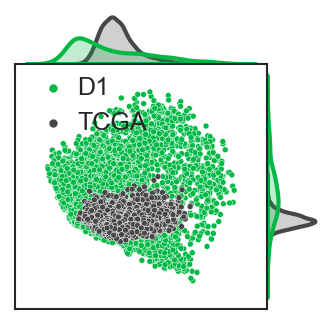

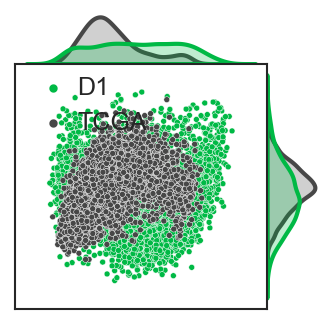

In [8]:
dataset_name = 'Mixed_N100K_segment_filtered'
for l_name in ['l_first', 'l_last']:
    print(f'--- {dataset_name}, {l_name} ---')
    umap_lower_dim = read_lower_dim(result_dir, dataset_name, layer_name=l_name, dataset_name_mapping=dataset_name_mapping, low_dim_type='PCA')
    plot_jointplot(data=umap_lower_dim, fig_result_path=os.path.join(fig_dir, f'{l_name}_{dataset_name}.svg'), color=dataset2color, low_dim_type='PC')

--- Mixed_N100K_segment_without_filtering, l_first ---
part1:  (5000, 4) total:  (10000, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


--- Mixed_N100K_segment_without_filtering, l_last ---
part1:  (5000, 4) total:  (10000, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


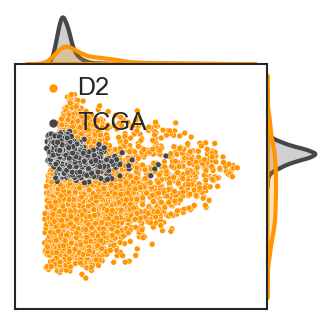

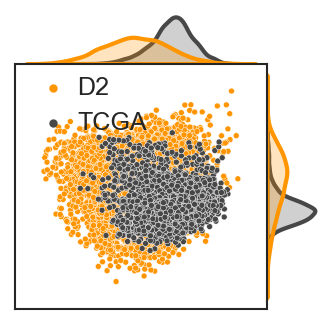

In [9]:
dataset_name = 'Mixed_N100K_segment_without_filtering'
for l_name in ['l_first', 'l_last']:
    print(f'--- {dataset_name}, {l_name} ---')
    umap_lower_dim = read_lower_dim(result_dir, dataset_name, layer_name=l_name, dataset_name_mapping=dataset_name_mapping, low_dim_type='PCA')
    plot_jointplot(data=umap_lower_dim, fig_result_path=os.path.join(fig_dir, f'{l_name}_{dataset_name}.svg'), color=dataset2color, low_dim_type='PC')

--- Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering, l_first ---
part1:  (5000, 4) total:  (14970, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


--- Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering, l_last ---
part1:  (5000, 4) total:  (14975, 4)


/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


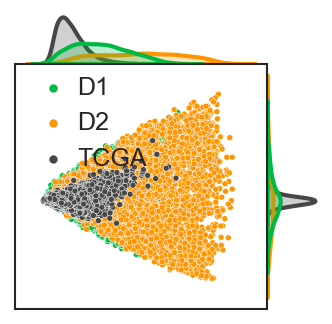

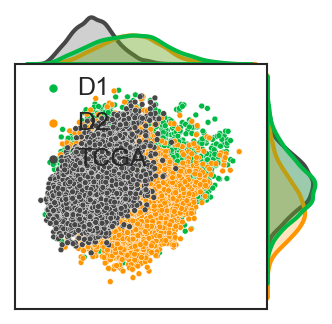

In [10]:
dataset_name = 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering'
for l_name in ['l_first', 'l_last']:
    print(f'--- {dataset_name}, {l_name} ---')
    umap_lower_dim = read_lower_dim(result_dir, dataset_name, layer_name=l_name, dataset_name_mapping=dataset_name_mapping, low_dim_type='PCA')
    plot_jointplot(data=umap_lower_dim, fig_result_path=os.path.join(fig_dir, f'{l_name}_{dataset_name}.svg'), color=dataset2color, low_dim_type='PC')

#### Prediction performance on test set

In [11]:
dataset_name = 'Mixed_N100K_random'
test_set_names = ['Test_set0', 'Test_set1', 'Test_set2', 'SCT_POS_N100_test']
# The directory of each test set
test_set2dir_name = {'SCT_POS_N100_test': os.path.join(dataset_dir, 'generated_sc_dataset_12ds_n_base100_all_subtypes'),
                      'Test_set0': os.path.join(dataset_dir, 'simulated_bulk_cell_dataset_subtypes_all_range', 'random_12ds_n_base100'),
                      'Test_set1': os.path.join(dataset_dir, 'simulated_bulk_cell_dataset_subtypes_all_range', 'segment_12ds_0.95_n_base100_19cancer_pca_0.9_median_gep'),
                      'Test_set2': os.path.join(dataset_dir, 'simulated_bulk_cell_dataset_subtypes_all_range', 'segment_12ds_no_filtering_n_base100_median_gep')}

In [12]:
def compare_y_y_pred_plot(y_true, y_pred,
                          show_columns: list = None, result_file_dir=None, annotation: dict = None,
                          y_label=None, x_label=None, dataset_name='average',
                          show_metrics: bool = False, figsize: tuple = (8, 8), ax=None, show_legend=False):
    """
    Plot y against y_pred to visualize the performance of prediction result

    :param y_true: this file contains the ground truth of cell fractions when it was simulated

    :param y_pred: this file contains the predicted value of y

    :param show_columns: this list contains the name of columns that want to plot in figure

    :param result_file_dir: where to save results

    :param annotation: annotations that need to show in figure, {anno_name: {col1: value1, col2: value2, ...}, ...}

    :param y_label: y label

    :param x_label: x label

    :param model_name: only for naming files

    :param show_metrics: show correlation and RMSE

    :param figsize: figure size

    :return: None
    """
    y_true = read_xy(a=y_true, xy='cell_frac')
    y_pred = read_xy(a=y_pred, xy='cell_frac')

    # sns.set(font_scale=font_scale)
    if ax is None:
        plt.figure(figsize=figsize)
    else:
        # Use the pyplot interface to change just one subplot...
        plt.sca(ax)
    all_x = []
    all_y = []
    for i, col in enumerate(show_columns):
        _y = y_true.loc[:, col]
        _x = y_pred.loc[:, col]
        all_x.append(_x)
        all_y.append(_y)
        plt.scatter(_x, _y, label=col, s=1, alpha=0.65, rasterized=True)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks([0, 1])
    plt.yticks([0, 0.5, 1])
    x_left, x_right = plt.xlim()
    y_bottom, y_top = plt.ylim()
    x_max = x_right
    y_max = y_top
    plt.plot([0, max(x_max, y_max)], [0, max(x_max, y_max)], linestyle='--', color='tab:gray')
    if show_metrics:  # show metrics in test set
        all_x = np.concatenate(all_x)
        all_y = np.concatenate(all_y)
        corr, p_value = get_corr(all_x, all_y, return_p_value=True)
        rmse = calculate_rmse(y_true=pd.DataFrame(all_x), y_pred=pd.DataFrame(all_y))
        plt.text(0.32 * x_max, 0.15 * y_max, '$r={:.2f}$'.format(corr), fontsize=5)
        if p_value < 0.001:
            plt.text(0.65 * x_max, 0.15 * y_max, '(p<0.001)'.format(p_value), fontsize=5)
        else:
            plt.text(0.65 * x_max, 0.15 * y_max, '(p={:.3f})'.format(p_value), fontsize=5)
        plt.text(0.32 * x_max, 0.05 * y_max, '$RMSE={:.3f}$'.format(rmse), fontsize=5)
    plt.xlabel('')
    plt.ylabel('')
    if show_legend:
        plt.legend(loc='upper left', fontsize=5, ncol=2)
    # plt.tight_layout()
    if result_file_dir:
        plt.savefig(os.path.join(result_file_dir, 'y_true_vs_y_pred_{}.svg'.format(dataset_name)), dpi=300)
    else:
        return ax
    # plt.show()

Model was trained by Mixed_N100K_random, tested on Test_set0
Model was trained by Mixed_N100K_random, tested on Test_set1
Model was trained by Mixed_N100K_random, tested on Test_set2
Model was trained by Mixed_N100K_random, tested on SCT_POS_N100_test
Model was trained by Mixed_N100K_segment_filtered, tested on Test_set0
Model was trained by Mixed_N100K_segment_filtered, tested on Test_set1
Model was trained by Mixed_N100K_segment_filtered, tested on Test_set2
Model was trained by Mixed_N100K_segment_filtered, tested on SCT_POS_N100_test
Model was trained by Mixed_N100K_segment_without_filtering, tested on Test_set0
Model was trained by Mixed_N100K_segment_without_filtering, tested on Test_set1
Model was trained by Mixed_N100K_segment_without_filtering, tested on Test_set2
Model was trained by Mixed_N100K_segment_without_filtering, tested on SCT_POS_N100_test
Model was trained by Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering, tested on Test_set0
Model was trained b

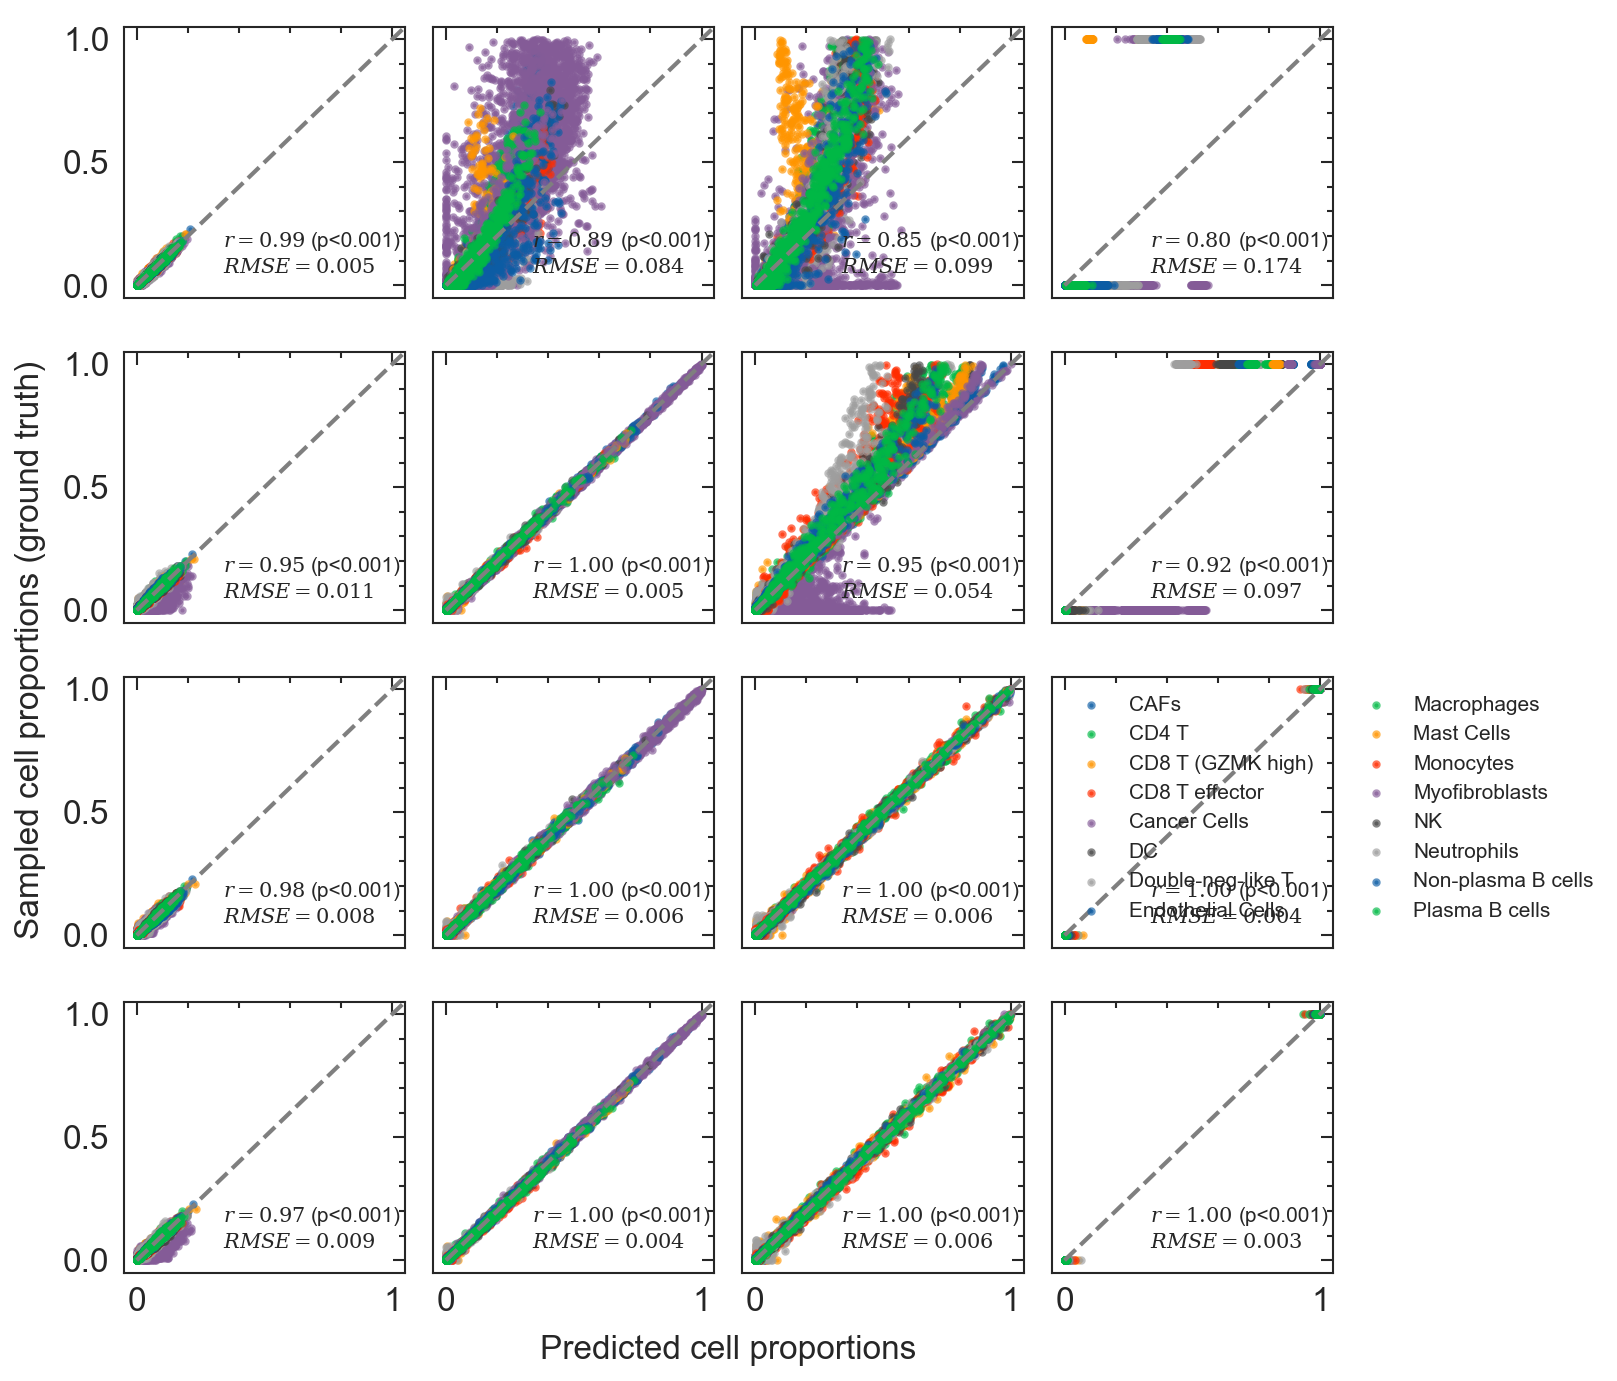

In [13]:
# y_true = ReadH5AD(y_true_file_path).get_cell_fraction()
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5.2, 5.5))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
train_set_names = ['Mixed_N100K_random', 'Mixed_N100K_segment_filtered', 'Mixed_N100K_segment_without_filtering', 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering']
cell_type2subtypes = {'B Cells': ['Non-plasma B cells', 'Plasma B cells'],
                      'CD4 T': ['CD4 T'], 'CD8 T': ['CD8 T (GZMK high)', 'CD8 T effector'],
                      'DC': ['DC'], 'Endothelial Cells': ['Endothelial Cells'],
                      'Cancer Cells': ['Cancer Cells'],
                      'Fibroblasts': ['CAFs', 'Myofibroblasts'], 'Macrophages': ['Macrophages'],
                      'Mast Cells': ['Mast Cells'], 'NK': ['NK'], 'Neutrophils': ['Neutrophils'],
                      'Double-neg-like T': ['Double-neg-like T'], 'Monocytes': ['Monocytes']}
all_cell_types = sorted([i for v in cell_type2subtypes.values() for i in v])
for i in range(4):
    train_set_name = train_set_names[i]
    for j in range(4):
        if j < 3 or i != 2:
            show_legend = False
        else:
            show_legend = True
        test_set_name = test_set_names[j]
        print(f'Model was trained by {train_set_name}, tested on {test_set_name}')
        y_true_file_path = os.path.join(test_set2dir_name[test_set_name], f'simu_bulk_exp_{test_set_name}_log2cpm1p.h5ad')
        y_pred_file_path = os.path.join(result_dir, train_set_name, test_set_name, f'{test_set_name}_pred_cell_frac.csv')
        compare_y_y_pred_plot(y_pred=y_pred_file_path, y_true=y_true_file_path, show_columns=all_cell_types, show_metrics=True, figsize=(1.5, 1.5), dataset_name=None, ax=axes[i, j], show_legend=show_legend)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Predicted cell proportions")
plt.ylabel("Sampled cell proportions (ground truth)")
        
plt.savefig(os.path.join(fig_dir, 'y_true_vs_y_pred_4_train_set_4_test_set.svg'), dpi=300)

#### Comparing predicted cell proportion of cancer cells with CPE

In [14]:
# outlier_file_path = os.path.join(dataset_dir, 'TCGA', 'outliers_TCGA.csv')
outlier_file_path = None
cpe_file_path = os.path.join(dataset_dir, 'cancer_purity', 'cancer_purity.csv')
dataset_names = ['Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering'] + \
                [f'Mixed_N100K_segment_filtered_{i}-Mixed_N100K_segment_without_filtering' for i in range(1, 5)] + \
                ['Mixed_N100K_random'] + [f'Mixed_N100K_random_{i}' for i in range(1, 5)] + \
                ['Mixed_N100K_segment_filtered'] + [f'Mixed_N100K_segment_filtered_{i}' for i in range(1, 5)] + \
                ['Mixed_N100K_segment_without_filtering'] + [f'Mixed_N100K_segment_without_filtering_{i}' for i in range(1, 5)]
dataset_names

['Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering',
 'Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering',
 'Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering',
 'Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering',
 'Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering',
 'Mixed_N100K_random',
 'Mixed_N100K_random_1',
 'Mixed_N100K_random_2',
 'Mixed_N100K_random_3',
 'Mixed_N100K_random_4',
 'Mixed_N100K_segment_filtered',
 'Mixed_N100K_segment_filtered_1',
 'Mixed_N100K_segment_filtered_2',
 'Mixed_N100K_segment_filtered_3',
 'Mixed_N100K_segment_filtered_4',
 'Mixed_N100K_segment_without_filtering',
 'Mixed_N100K_segment_without_filtering_1',
 'Mixed_N100K_segment_without_filtering_2',
 'Mixed_N100K_segment_without_filtering_3',
 'Mixed_N100K_segment_without_filtering_4']

In [15]:
def read_pred_result(file_path, col_names, outlier_file_path=None):
    try:
        cell_prop = pd.read_csv(file_path, index_col='sample_id')
    except:
        cell_prop = pd.read_csv(file_path, index_col=0)
    sample_inx = cell_prop.index
    if not (outlier_file_path is None):
        outliers = pd.read_csv(outlier_file_path, index_col=0)
        print(f'{outliers.shape[0]} outliers will be removed')
        sample_inx = cell_prop.loc[~cell_prop.index.isin(outliers.index), :].index
    cell_prop = cell_prop.loc[sample_inx, col_names].copy()
    return cell_prop

In [16]:
cancer_cell_prop_all = None
# sample_id = None
for ds in dataset_names:
    y_pred_file_path = os.path.join(result_dir, ds, 'predicted_cell_fraction_tcga', 'DeSide', 'all_predicted_cell_fraction_by_DeSide.csv')
    _ = read_pred_result(y_pred_file_path, col_names=['Cancer Cells', 'cancer_type'], outlier_file_path=outlier_file_path)
    if cancer_cell_prop_all is None:
        cancer_cell_prop_all = pd.DataFrame(index=_.index, columns=dataset_names)
    else:
        assert np.all(cancer_cell_prop_all.index == _.index)
    if 'cancer_type' not in cancer_cell_prop_all.columns:
        cancer_cell_prop_all['cancer_type'] = _['cancer_type']
    cancer_cell_prop_all[ds] = _['Cancer Cells']
cancer_cell_prop_all.shape

(7699, 21)

In [17]:
cancer_cell_prop_all.head(2)

,Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering,Mixed_N100K_random,Mixed_N100K_random_1,Mixed_N100K_random_2,Mixed_N100K_random_3,Mixed_N100K_random_4,...,Mixed_N100K_segment_filtered_1,Mixed_N100K_segment_filtered_2,Mixed_N100K_segment_filtered_3,Mixed_N100K_segment_filtered_4,Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_without_filtering_1,Mixed_N100K_segment_without_filtering_2,Mixed_N100K_segment_without_filtering_3,Mixed_N100K_segment_without_filtering_4,cancer_type
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-CV-5442-01A,0.950,0.917,0.941,0.940,0.971,0.338,0.499,0.203,0.313,0.0,...,0.940,0.897,0.972,0.948,0.901,0.914,0.730,0.750,0.817,HNSC
TCGA-CR-7392-01A,0.458,0.463,0.463,0.467,0.526,0.037,0.214,0.000,0.177,0.0,...,0.534,0.441,0.442,0.471,0.553,0.622,0.521,0.376,0.578,HNSC


In [18]:
rep_5_d1d2 = dataset_names[:5]
rep_5_d0 = dataset_names[5:10]
rep_5_d1 = dataset_names[10:15]
rep_5_d2 = dataset_names[15:]
rep_dict = {'rep_5_d1d2': rep_5_d1d2, 'rep_5_d0': rep_5_d0, 'rep_5_d1': rep_5_d1, 'rep_5_d2': rep_5_d2}
for k, v in rep_dict.items():
    print(k, v)

rep_5_d1d2 ['Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering', 'Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering', 'Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering', 'Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering', 'Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering']
rep_5_d0 ['Mixed_N100K_random', 'Mixed_N100K_random_1', 'Mixed_N100K_random_2', 'Mixed_N100K_random_3', 'Mixed_N100K_random_4']
rep_5_d1 ['Mixed_N100K_segment_filtered', 'Mixed_N100K_segment_filtered_1', 'Mixed_N100K_segment_filtered_2', 'Mixed_N100K_segment_filtered_3', 'Mixed_N100K_segment_filtered_4']
rep_5_d2 ['Mixed_N100K_segment_without_filtering', 'Mixed_N100K_segment_without_filtering_1', 'Mixed_N100K_segment_without_filtering_2', 'Mixed_N100K_segment_without_filtering_3', 'Mixed_N100K_segment_without_filtering_4']


In [19]:
cancer_purity = read_cancer_purity(cpe_file_path, sample_names=cancer_cell_prop_all.index.to_list())
print(cancer_purity.shape)
cancer_purity.head(2)

(7452, 7)


,Cancer type,ESTIMATE,ABSOLUTE,LUMP,IHC,CPE,Unnamed: 7
Sample ID,,,,,,,
TCGA-AX-A3GB-01A,UCEC,0.8707,0.34,0.7963,0.900,0.8151,NaN
TCGA-BG-A0LX-01A,UCEC,NaN,0.82,NaN,0.875,0.9150,NaN


In [20]:
cancer_cell_prop = cancer_cell_prop_all.merge(cancer_purity, left_index=True, right_index=True)
cancer_cell_prop.shape

(7452, 28)

In [21]:
# calculate the RMSE between predicted cell proprotions and CPE of each tumor type
cancer_cell_vs_cpe_rmse = pd.DataFrame(index=cancer_cell_prop['cancer_type'].unique(), columns=dataset_names)
for cancer_type, _group in cancer_cell_prop.groupby('cancer_type'):
    for ds in dataset_names:
        cancer_cell_vs_cpe_rmse.loc[cancer_type, ds] = calculate_rmse(pd.DataFrame(_group[ds]), pd.DataFrame(_group['CPE']))
cancer_cell_vs_cpe_rmse

,Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering,Mixed_N100K_random,Mixed_N100K_random_1,Mixed_N100K_random_2,Mixed_N100K_random_3,Mixed_N100K_random_4,Mixed_N100K_segment_filtered,Mixed_N100K_segment_filtered_1,Mixed_N100K_segment_filtered_2,Mixed_N100K_segment_filtered_3,Mixed_N100K_segment_filtered_4,Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_without_filtering_1,Mixed_N100K_segment_without_filtering_2,Mixed_N100K_segment_without_filtering_3,Mixed_N100K_segment_without_filtering_4
HNSC,0.116143,0.117323,0.119696,0.120294,0.132748,0.612645,0.304489,0.663431,0.531628,0.652726,0.114797,0.131721,0.118559,0.120819,0.130672,0.115804,0.131739,0.105454,0.102337,0.122016
ACC,0.134205,0.129407,0.087114,0.113979,0.097873,0.746443,0.752684,0.892888,0.800116,0.87468,0.115063,0.144746,0.123259,0.143181,0.151116,0.151926,0.129523,0.139274,0.123198,0.144234
LUAD,0.095784,0.093347,0.095098,0.098066,0.099203,0.546235,0.462129,0.641858,0.59639,0.562531,0.093851,0.095436,0.097274,0.100669,0.107107,0.086044,0.109823,0.095193,0.0824,0.09214
CESC,0.098092,0.099485,0.105886,0.103067,0.110984,0.63805,0.384292,0.755599,0.609582,0.713632,0.101383,0.107875,0.102332,0.100705,0.110976,0.092797,0.10644,0.082653,0.094727,0.091642
UCEC,0.108058,0.11018,0.112603,0.110272,0.109666,0.644514,0.579191,0.831682,0.73244,0.761191,0.107799,0.108769,0.11204,0.108238,0.112727,0.111279,0.117097,0.115787,0.129001,0.115998
LIHC,0.119405,0.107513,0.165881,0.100212,0.115045,0.783055,0.654372,0.787164,0.778173,0.784385,0.10305,0.094331,0.101383,0.095887,0.11243,0.115019,0.110518,0.142473,0.104787,0.12479
KICH,0.097919,0.116528,0.06902,0.080622,0.081973,0.563351,0.532916,0.883312,0.767239,0.796021,0.119068,0.169481,0.135495,0.128056,0.144132,0.11175,0.165067,0.056542,0.11409,0.112992
PRAD,0.119526,0.125617,0.121205,0.122032,0.123423,0.643299,0.474525,0.876834,0.746789,0.866111,0.12566,0.121748,0.132294,0.128625,0.144957,0.113181,0.1201,0.106982,0.118397,0.117917
READ,0.101904,0.098182,0.100994,0.094112,0.097947,0.511966,0.501425,0.781375,0.768176,0.755338,0.102334,0.101931,0.10742,0.102269,0.11095,0.08659,0.078257,0.082689,0.085167,0.082237
GBM,0.118917,0.149259,0.130043,0.138867,0.139283,0.674759,0.709442,0.819268,0.583714,0.806421,0.130801,0.112038,0.133177,0.128752,0.153397,0.138426,0.129938,0.125479,0.125413,0.118998


In [22]:
# calculate average and STD of RMSE across different tumor types
for k, rep in rep_dict.items():
    cancer_cell_vs_cpe_rmse[f'{k}_mean'] = cancer_cell_vs_cpe_rmse.loc[:, rep].mean(axis=1)
    cancer_cell_vs_cpe_rmse[f'{k}_std'] = cancer_cell_vs_cpe_rmse.loc[:, rep].std(axis=1)
    cancer_cell_vs_cpe_rmse.head(2)
cancer_cell_vs_cpe_rmse.head(2)

,Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering,Mixed_N100K_random,Mixed_N100K_random_1,Mixed_N100K_random_2,Mixed_N100K_random_3,Mixed_N100K_random_4,...,Mixed_N100K_segment_without_filtering_3,Mixed_N100K_segment_without_filtering_4,rep_5_d1d2_mean,rep_5_d1d2_std,rep_5_d0_mean,rep_5_d0_std,rep_5_d1_mean,rep_5_d1_std,rep_5_d2_mean,rep_5_d2_std
HNSC,0.116143,0.117323,0.119696,0.120294,0.132748,0.612645,0.304489,0.663431,0.531628,0.652726,...,0.102337,0.122016,0.121241,0.006653,0.552984,0.14825,0.123313,0.007520,0.115470,0.012046
ACC,0.134205,0.129407,0.087114,0.113979,0.097873,0.746443,0.752684,0.892888,0.800116,0.87468,...,0.123198,0.144234,0.112516,0.020109,0.813362,0.06786,0.135473,0.015458,0.137631,0.011453


In [23]:
# calculate the correlation between predicted cell proprotions and CPE of each tumor type
cancer_cell_vs_cpe_corr = pd.DataFrame(index=cancer_cell_prop['cancer_type'].unique(), columns=dataset_names)
for cancer_type, _group in cancer_cell_prop.groupby('cancer_type'):
    for ds in dataset_names:
        cancer_cell_vs_cpe_corr.loc[cancer_type, ds] = get_corr(_group[ds], _group['CPE'])
cancer_cell_vs_cpe_corr

/Users/belter/miniconda3/envs/deside_obj/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering,Mixed_N100K_random,Mixed_N100K_random_1,Mixed_N100K_random_2,Mixed_N100K_random_3,Mixed_N100K_random_4,Mixed_N100K_segment_filtered,Mixed_N100K_segment_filtered_1,Mixed_N100K_segment_filtered_2,Mixed_N100K_segment_filtered_3,Mixed_N100K_segment_filtered_4,Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_without_filtering_1,Mixed_N100K_segment_without_filtering_2,Mixed_N100K_segment_without_filtering_3,Mixed_N100K_segment_without_filtering_4
HNSC,0.705001,0.681207,0.685383,0.683763,0.654833,0.158341,0.568322,0.105341,0.017113,-0.036492,0.678858,0.682387,0.683956,0.713049,0.68321,0.694114,0.642482,0.676711,0.685858,0.666374
ACC,0.784109,0.827812,0.771862,0.797155,0.812374,0.227073,0.004625,0.062186,0.111475,-0.38464,0.831618,0.778341,0.824089,0.786111,0.765371,0.851473,0.816896,0.756054,0.811963,0.724137
LUAD,0.782562,0.785948,0.789741,0.777834,0.756822,0.389248,0.642709,0.03107,0.267034,0.090435,0.765183,0.785805,0.766227,0.794401,0.757716,0.792997,0.705379,0.741043,0.79576,0.761128
CESC,0.67028,0.665493,0.649787,0.650069,0.623044,0.073087,0.454762,-0.003967,-0.042209,-0.21368,0.643901,0.653131,0.637509,0.673468,0.634531,0.686664,0.605139,0.690016,0.677026,0.663268
UCEC,0.514041,0.50074,0.497596,0.50748,0.500318,0.213928,0.285707,-0.022904,-0.069637,-0.089479,0.511566,0.519561,0.468375,0.527188,0.498379,0.459452,0.433264,0.430353,0.451871,0.4627
LIHC,0.637889,0.660227,0.598313,0.659897,0.666815,-0.135007,0.33008,NaN,0.07504,-0.200754,0.665262,0.705199,0.648075,0.708966,0.649935,0.594215,0.619673,0.194562,0.585848,0.315121
KICH,0.885078,0.895667,0.85532,0.886312,0.89285,0.580957,0.618532,0.001944,0.23401,0.154225,0.875037,0.755364,0.850411,0.827175,0.839507,0.845691,0.834545,0.863108,0.867203,0.830234
PRAD,0.537522,0.526371,0.532442,0.522649,0.521425,0.318272,0.437749,-0.014222,0.019258,-0.169799,0.520483,0.514315,0.49249,0.516901,0.501394,0.50389,0.477746,0.53459,0.530149,0.508506
READ,0.64257,0.650996,0.653642,0.654081,0.646792,0.472783,0.377599,0.125907,0.119972,-0.018692,0.641195,0.645722,0.631607,0.650383,0.623209,0.640542,0.627455,0.642485,0.649678,0.64225
GBM,0.766513,0.777364,0.775026,0.756155,0.766662,0.176168,0.13129,0.093806,0.351387,0.013895,0.767759,0.764255,0.752923,0.751598,0.723088,0.767599,0.763476,0.716648,0.670046,0.736843


In [24]:
for k, rep in rep_dict.items():
    cancer_cell_vs_cpe_corr[f'{k}_mean'] = cancer_cell_vs_cpe_corr.loc[:, rep].mean(axis=1)
    cancer_cell_vs_cpe_corr[f'{k}_std'] = cancer_cell_vs_cpe_corr.loc[:, rep].std(axis=1)
    cancer_cell_vs_cpe_corr.head(2)
cancer_cell_vs_cpe_corr.head(2)

,Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering,Mixed_N100K_random,Mixed_N100K_random_1,Mixed_N100K_random_2,Mixed_N100K_random_3,Mixed_N100K_random_4,...,Mixed_N100K_segment_without_filtering_3,Mixed_N100K_segment_without_filtering_4,rep_5_d1d2_mean,rep_5_d1d2_std,rep_5_d0_mean,rep_5_d0_std,rep_5_d1_mean,rep_5_d1_std,rep_5_d2_mean,rep_5_d2_std
HNSC,0.705001,0.681207,0.685383,0.683763,0.654833,0.158341,0.568322,0.105341,0.017113,-0.036492,...,0.685858,0.666374,0.682037,0.017904,0.162525,0.239119,0.688292,0.013977,0.673108,0.020000
ACC,0.784109,0.827812,0.771862,0.797155,0.812374,0.227073,0.004625,0.062186,0.111475,-0.38464,...,0.811963,0.724137,0.798662,0.022193,0.004144,0.232239,0.797106,0.029152,0.792105,0.051119


In [25]:
cancer_cell_vs_cpe_corr.to_csv(os.path.join(fig_dir, 'cancer_cell_vs_cpe_corr.csv'))
cancer_cell_vs_cpe_rmse.to_csv(os.path.join(fig_dir, 'cancer_cell_vs_cpe_rmse.csv'))

In [26]:
cancer_cell_vs_cpe_rmse = cancer_cell_vs_cpe_rmse.sort_values(by=['rep_5_d1d2_mean'], ascending=False)
cancer_cell_vs_cpe_rmse.head(2)

,Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_1-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_2-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_3-Mixed_N100K_segment_without_filtering,Mixed_N100K_segment_filtered_4-Mixed_N100K_segment_without_filtering,Mixed_N100K_random,Mixed_N100K_random_1,Mixed_N100K_random_2,Mixed_N100K_random_3,Mixed_N100K_random_4,...,Mixed_N100K_segment_without_filtering_3,Mixed_N100K_segment_without_filtering_4,rep_5_d1d2_mean,rep_5_d1d2_std,rep_5_d0_mean,rep_5_d0_std,rep_5_d1_mean,rep_5_d1_std,rep_5_d2_mean,rep_5_d2_std
KIRC,0.272324,0.278101,0.225655,0.24376,0.260923,0.632836,0.565335,0.669372,0.635202,0.614879,...,0.153068,0.166992,0.256152,0.021504,0.623525,0.038032,0.278752,0.013607,0.160384,0.017117
THCA,0.202738,0.206036,0.143332,0.199695,0.201976,0.639717,0.561704,0.85449,0.679304,0.801197,...,0.197736,0.181745,0.190755,0.026608,0.707282,0.119406,0.224691,0.010856,0.191898,0.016257


In [27]:
cancer_cell_vs_cpe_corr = cancer_cell_vs_cpe_corr.loc[cancer_cell_vs_cpe_rmse.index, :]

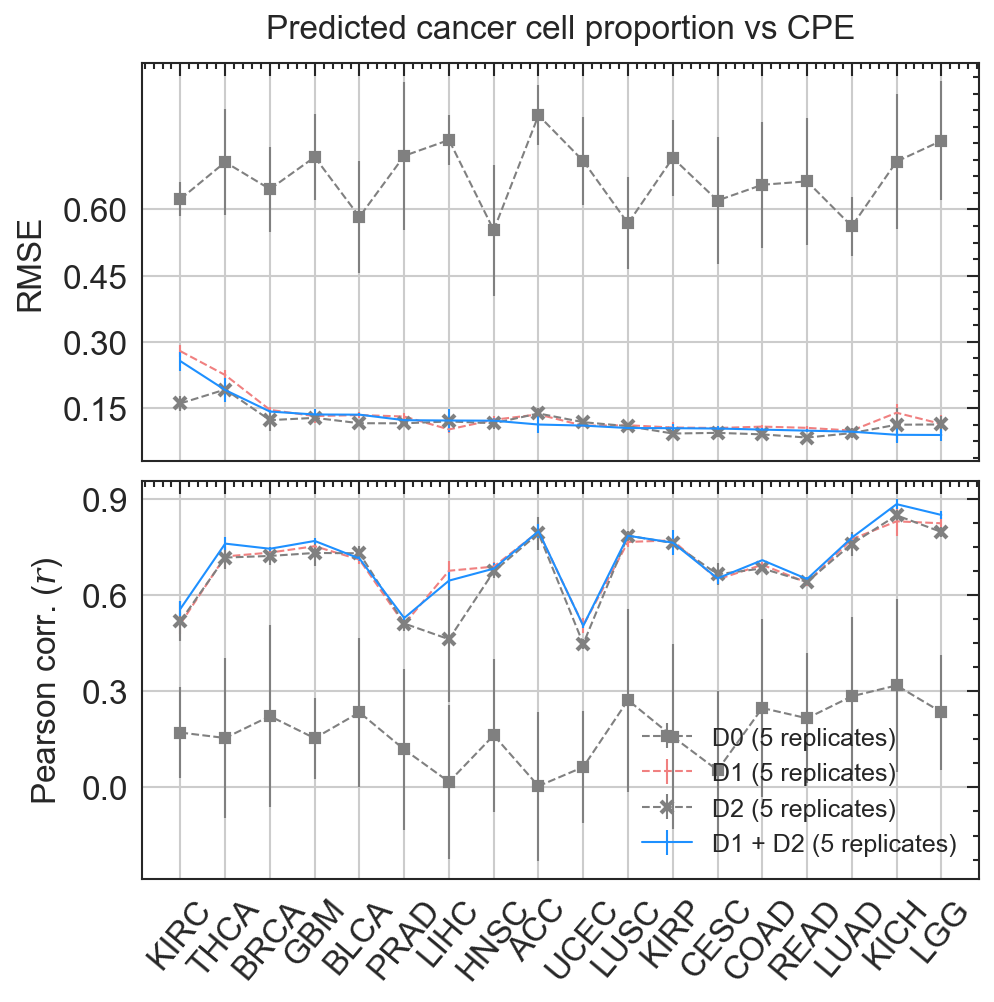

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(3.6, 3.6), sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.05)
for i in range(2):
    ax = axes[i]
    if i == 0:
        # ax.plot(cancer_cell_vs_cpe_rmse['Mixed_N100K_random'], label='Mix_N100K_R', c='grey', linewidth=0.5, linestyle='--', marker='.', ms=3)
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_rmse['rep_5_d0_mean'], yerr=cancer_cell_vs_cpe_rmse['rep_5_d0_std'], 
                    label='D0 (5 replicates)', c='grey', linewidth=0.5, linestyle='--', marker='s', ms=2)
        
        # ax.plot(cancer_cell_vs_cpe_rmse['Mixed_N100K_segment_filtered'], label='Mix_N100K_SF', c='grey', linewidth=0.5, linestyle='--')
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_rmse['rep_5_d1_mean'], yerr=cancer_cell_vs_cpe_rmse['rep_5_d1_std'], 
                    label='D1 (5 replicates)', c='lightcoral', linewidth=0.5, linestyle='--')
        
        # ax.plot(cancer_cell_vs_cpe_rmse['Mixed_N100K_segment_without_filtering'], label='Mix_N100K_SNF', c='grey', linewidth=0.5, linestyle='--', marker='x', ms=3)
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_rmse['rep_5_d2_mean'], yerr=cancer_cell_vs_cpe_rmse['rep_5_d2_std'], 
                    label='D2 (5 replicates)', c='grey', linewidth=0.5, linestyle='--', ms=3, marker='x')
        
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_rmse['rep_5_d1d2_mean'], yerr=cancer_cell_vs_cpe_rmse['rep_5_d1d2_std'], label='D1 + D2 (5 replicates)', linewidth=0.5, c='dodgerblue')
        ax.grid()
        # ax.legend(fontsize=6, loc='best')
        ax.set_yticks([0.15, 0.3, 0.45, 0.6])
        ax.set_ylabel('RMSE')
        ax.set_title('Predicted cancer cell proportion vs CPE', fontsize=8)
    if i == 1:
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_corr['rep_5_d0_mean'], yerr=cancer_cell_vs_cpe_corr['rep_5_d0_std'], label='D0 (5 replicates)', c='grey', linewidth=0.5, linestyle='--', marker='s', ms=2)
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_corr['rep_5_d1_mean'], yerr=cancer_cell_vs_cpe_corr['rep_5_d1_std'], label='D1 (5 replicates)', c='lightcoral', linewidth=0.5, linestyle='--')
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_corr['rep_5_d2_mean'], yerr=cancer_cell_vs_cpe_corr['rep_5_d2_std'], label='D2 (5 replicates)', c='grey', linewidth=0.5, linestyle='--', marker='x', ms=3)
        ax.errorbar(x=range(18), y=cancer_cell_vs_cpe_corr['rep_5_d1d2_mean'], yerr=cancer_cell_vs_cpe_corr['rep_5_d1d2_std'], label='D1 + D2 (5 replicates)', linewidth=0.5, c='dodgerblue')
        ax.set_ylabel('Pearson corr. ($r$)')
        ax.set_xticks(range(18), cancer_cell_vs_cpe_rmse.index.to_list(), rotation=50, fontsize=8)
        ax.set_yticks([0, 0.3, 0.6, 0.9])
        ax.grid()
        ax.legend(fontsize=6, loc='best')

plt.savefig(os.path.join(fig_dir, 'pred_cancer_cell_prop_vs_cpe_rmse_and_corr.svg'), dpi=300)

#### Compare the previous version model and the current model
- The previous model: trained on 7 datasets without layer normalizaion and pathway profiles

In [29]:
metrics_values = []
result_dir2 = r'../results/whole_workflow_20230216_7ds_new_hp_without_caner_cell/DeSide_009/'
training_set2file_path = {'Improved model': os.path.join(result_dir, 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering', 'predicted_cell_fraction_tcga', 'pred_cancer_cell_prop_vs_cpe-deside-metrics.csv'), 
                          'Previous model': os.path.join(result_dir2, 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering', 'predicted_cell_fraction_tcga', 'pred_cancer_cell_prop_vs_cpe-deside-metrics.csv')
                         }
for ds, fp in training_set2file_path.items():
    print(f'Dealing with {ds}...')
    current_metrics = pd.read_csv(fp, index_col=0)
    current_metrics['dataset'] = ds
    metrics_values.append(current_metrics)

Dealing with Improved model...
Dealing with Previous model...


In [30]:
metrics_df = pd.concat(metrics_values, axis=0)
metrics_df.index.name = 'cancer_type'
metrics_df = metrics_df.reset_index()
print(metrics_df.shape)
metrics_df.head(2)

(36, 5)


,cancer_type,corr,rmse,ccc,dataset
0,ACC,0.784109,0.134205,0.555562,Improved model
1,BLCA,0.722290,0.130579,0.681812,Improved model


In [31]:
color_palette = [sns.color_palette("Paired")[i] for i in [1, 5]]
sns.color_palette(color_palette)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

In [32]:
cancer_types = metrics_df['cancer_type'].unique()

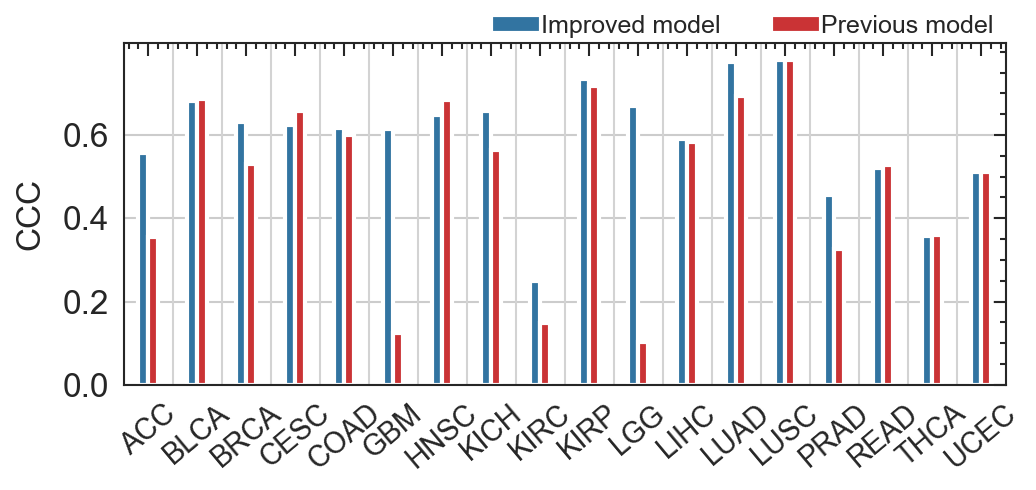

In [33]:
fig, ax2 = plt.subplots(1, 1, figsize=(3.6, 1.8))

width = 0.4
g1 = sns.barplot(data=metrics_df, x='cancer_type', y='ccc', hue='dataset', ax=ax2, width=width, palette=color_palette, hue_order=['Improved model', 'Previous model'], order=cancer_types)
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper right", bbox_to_anchor=(1, 1.12), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
ax2.grid(axis='y')
for _x in range(len(cancer_types)):
    ax2.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(40)
# ax.legend(fontsize=6, loc='best')
ax2.set_yticks([0.0, 0.2, 0.4, 0.6])
ax2.set_xticks(range(len(cancer_types)), cancer_types, fontsize=7)
ax2.set_xlabel('')
ax2.set_ylabel('CCC')

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cell_proportion_comparison_new_old_model.svg'), dpi=300)

In [34]:
def compare_cell_fraction_across_cancer_type(merged_cell_fraction: pd.DataFrame, result_dir='.', cell_type: str = '',
                                             xlabel: str = 'Cancer Type',
                                             ylabel: str = 'Tumor purity in each sample (CPE)',
                                             outlier_file_path: str = None, cell_type2max: float = 0.0):
    """
    Specific plotting for file cancer_purity.csv, downloaded from Aran, D., Sirota, M. & Butte,
    A. Systematic pan-cancer analysis of tumour purity. Nat Commun 6, 8971 (2015). https://doi.org/10.1038/ncomms9971

    And other predicted cell fractions across all cancer types can be plotted.

    :param merged_cell_fraction: merged cell fraction predicted by DeSide

    :param cell_type: current cell type to plot

    :param result_dir: where to save result

    :param xlabel: x label

    :param ylabel: y label

    :param outlier_file_path:

    :param cell_type2max: max cell fraction to keep when plotting

    :return: None
    """
    x = 'cancer_type'
    check_dir(result_dir)

    if outlier_file_path is not None:
        outlier_samples = pd.read_csv(outlier_file_path, index_col=0)
        if outlier_samples.shape[0] > 0:  # remove outliers
            print(f'   {outlier_samples.shape[0]} outlier samples will be removed...')
            merged_cell_fraction = merged_cell_fraction.loc[~merged_cell_fraction.index.isin(outlier_samples.index),
                                   :].copy()
    # sns.set(font_scale=font_scale)
    plt.figure(figsize=(3.6, 1.8))
    # Draw a nested boxplot to show bills by day and time
    # sns.set_color_codes('bright')
    # sample_labels = list(purity['Cancer type'].unique())
    current_cancer_type_frac = merged_cell_fraction.loc[:, [cell_type, 'cancer_type']]
    if cell_type2max > 0:
        current_cancer_type_frac.loc[current_cancer_type_frac[cell_type] > cell_type2max, cell_type] = cell_type2max
    # mean cell fraction of each cancer type
    mean_for_each_cancer_type = current_cancer_type_frac.groupby('cancer_type').mean().sort_values(by=cell_type)
    cancer_type_order = mean_for_each_cancer_type.index.to_list()
    # print(mean_for_each_cancer_type)
    ax = sns.boxplot(x=x, y=cell_type, palette=sns.color_palette("muted"), whis=[0, 100],
                     data=current_cancer_type_frac, showfliers=False, order=cancer_type_order)
    # ax.tick_params(labelsize=11)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    # print(ax.get_xticklabels())
    ax.set_xticks(range(0, len(ax.get_xticklabels())), ax.get_xticklabels(), fontsize=7, rotation=40)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # Add in points to show each observation, http://seaborn.pydata.org/examples/horizontal_boxplot.html
    sns.stripplot(x=x, y=cell_type, data=current_cancer_type_frac,
                  size=2, color=".4", linewidth=0, dodge=True, order=cancer_type_order, ax=ax)
    ax.grid(True, axis='y')
    # remove the top and right ticks
    ax.tick_params(axis='x', which='both', top=False)
    ax.tick_params(axis='y', which='both', right=False)
    # sns.despine(offset=10, trim=True, left=True)

    # handles, labels = ax.get_legend_handles_labels()
    # n_half_label = int(len(labels)/2)
    # plt.legend(handles[0:n_half_label], labels[0:n_half_label], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    file_name = f'pred_{cell_type}_across_cancers.svg'
    # plt.show()
    plt.savefig(os.path.join(result_dir, file_name), dpi=300)
    # plt.close()

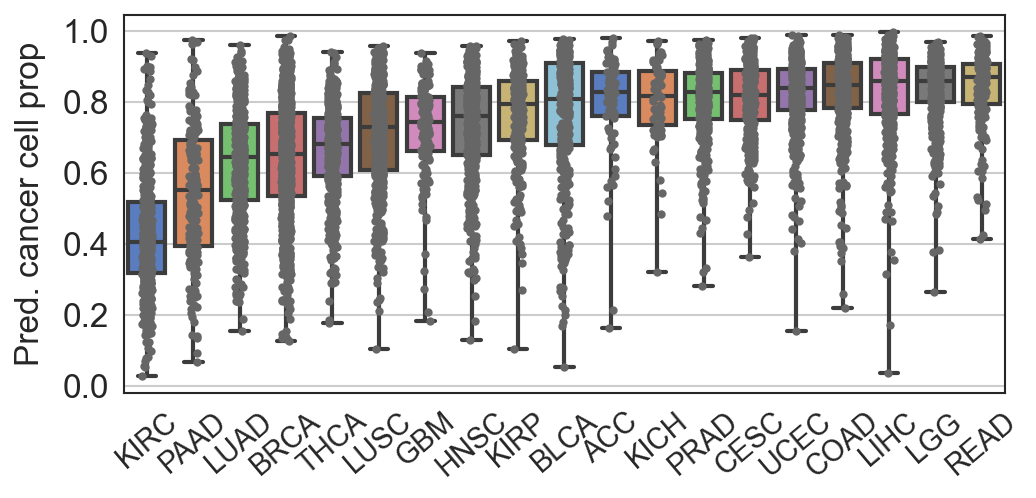

In [35]:
y_pred_deside_fp = os.path.join(result_dir, 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering', 'predicted_cell_fraction_tcga', 'merged_all_signature_score_and_cell_fraction_by_DeSide.csv')
pred_cancer_prop = pd.read_csv(y_pred_deside_fp, index_col=0)
compare_cell_fraction_across_cancer_type(merged_cell_fraction=pred_cancer_prop, result_dir=fig_dir, cell_type='Cancer Cells', ylabel='Pred. cancer cell prop', xlabel='')